In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mental-health-corpus/mental_health.csv


In [2]:
import string
from wordcloud import WordCloud
from collections import Counter

import re
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
def plot_confusion_matrix(y_true, y_pred, ax, cmap='YlGnBu'):
    cm = confusion_matrix(y_true, y_pred)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    # Добавьте числа в ячейки матрицы, если нужно:
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center")

def plot_roc(y_true, y_prob, ax, cmap='summer'):
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])  # Предполагается, что y_prob — вероятности для класса 1
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")
    
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten, LSTM, Bidirectional, Embedding, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time

In [3]:
data = pd.read_csv('../input/mental-health-corpus/mental_health.csv')
data.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [4]:
print(data.shape)

(27977, 2)


In [5]:
data.isnull().sum()

text     0
label    0
dtype: int64

label
0    14139
1    13838
Name: count, dtype: int64

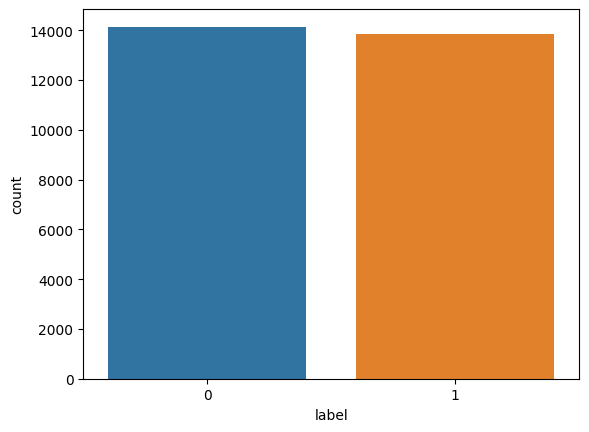

In [6]:
sns.countplot(data=data, x="label")
data['label'].value_counts()

In [7]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

In [8]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

In [9]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punc)

In [10]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

In [11]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

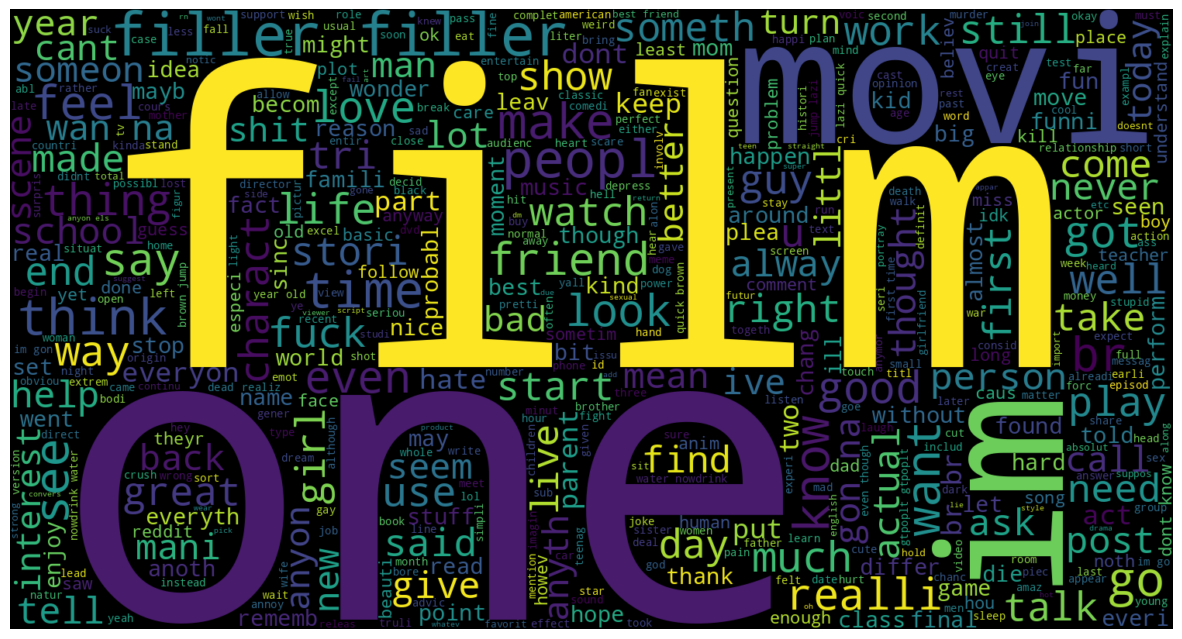

In [12]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

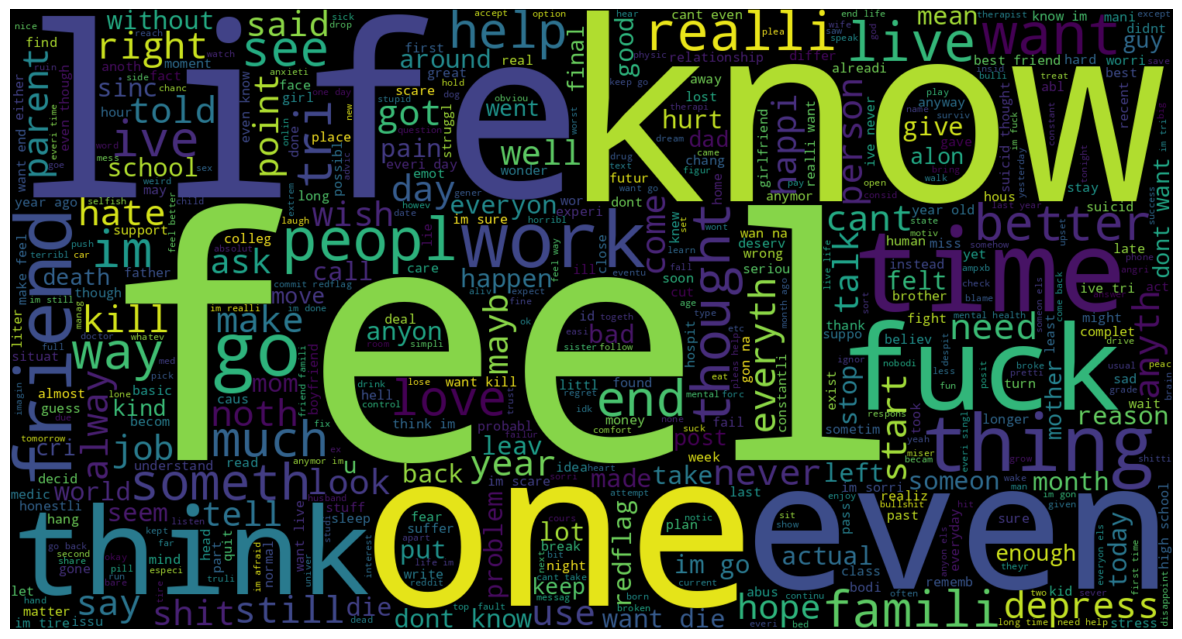

In [13]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

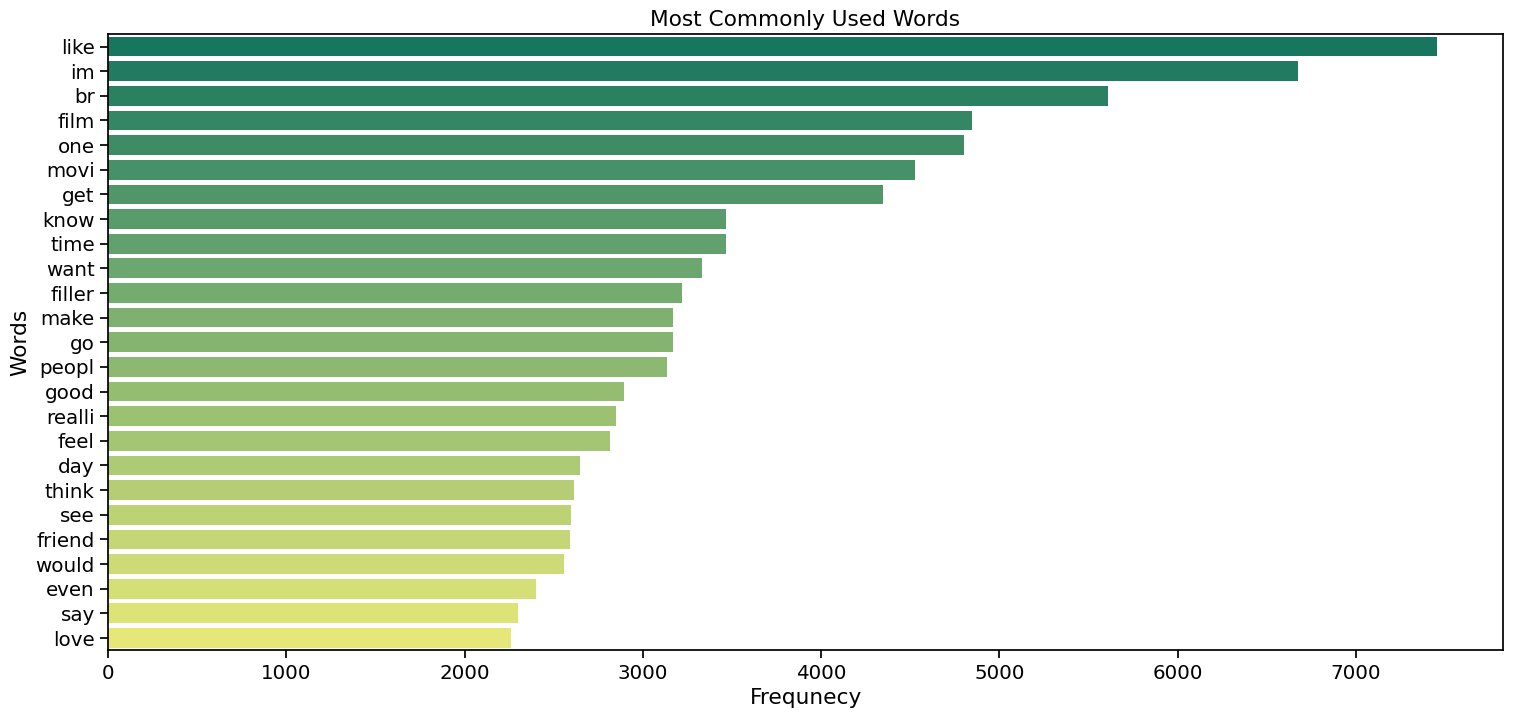

In [14]:
all_spam_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

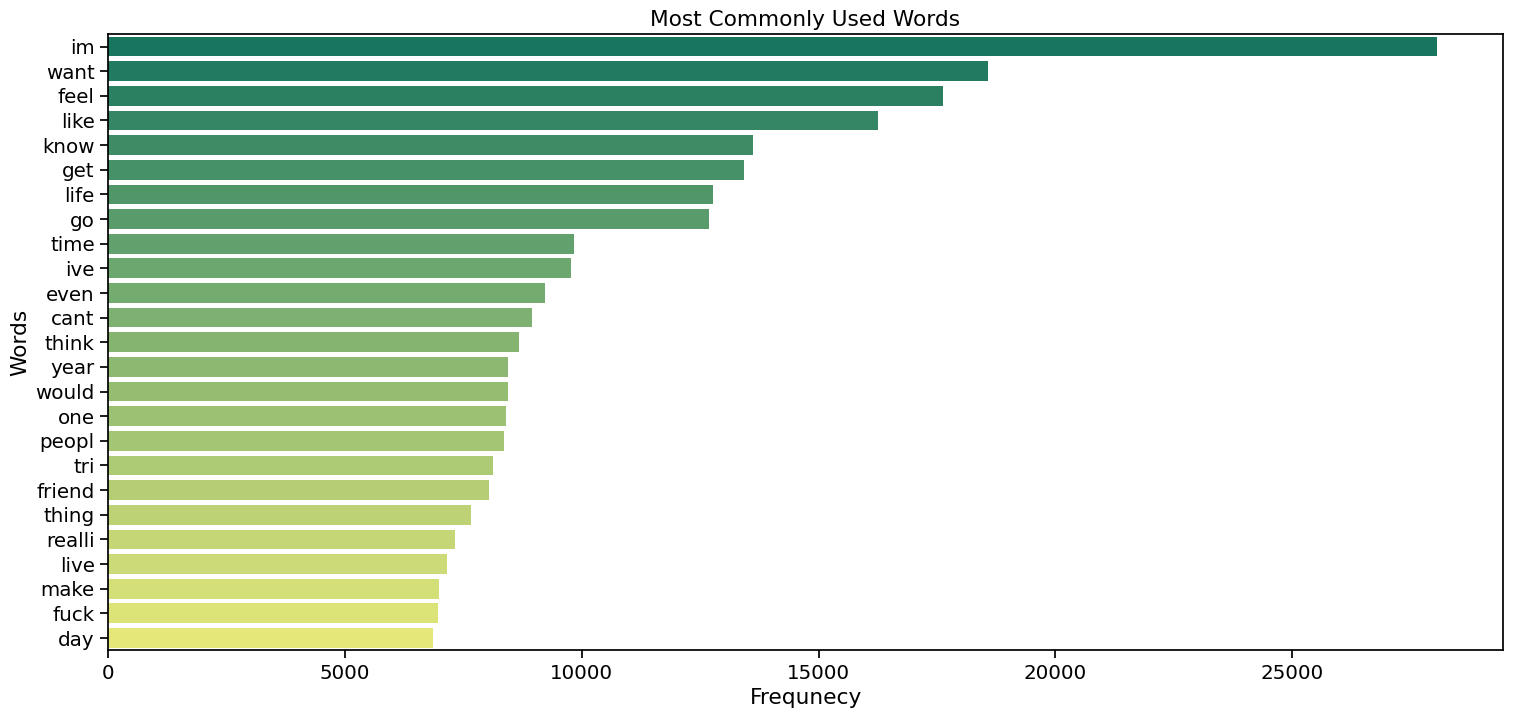

In [15]:
all_spam_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

In [16]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [17]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [18]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, ax=ax[0], cmap='YlGnBu')
    
    # ROC (без plot_macro и plot_micro)
    plot_roc(y_test, y_prob, ax=ax[1], cmap='summer')
    
    plt.show()

Accuracy of the model: 0.888
Precision Score of the model: 0.839
Recall Score of the model: 0.957


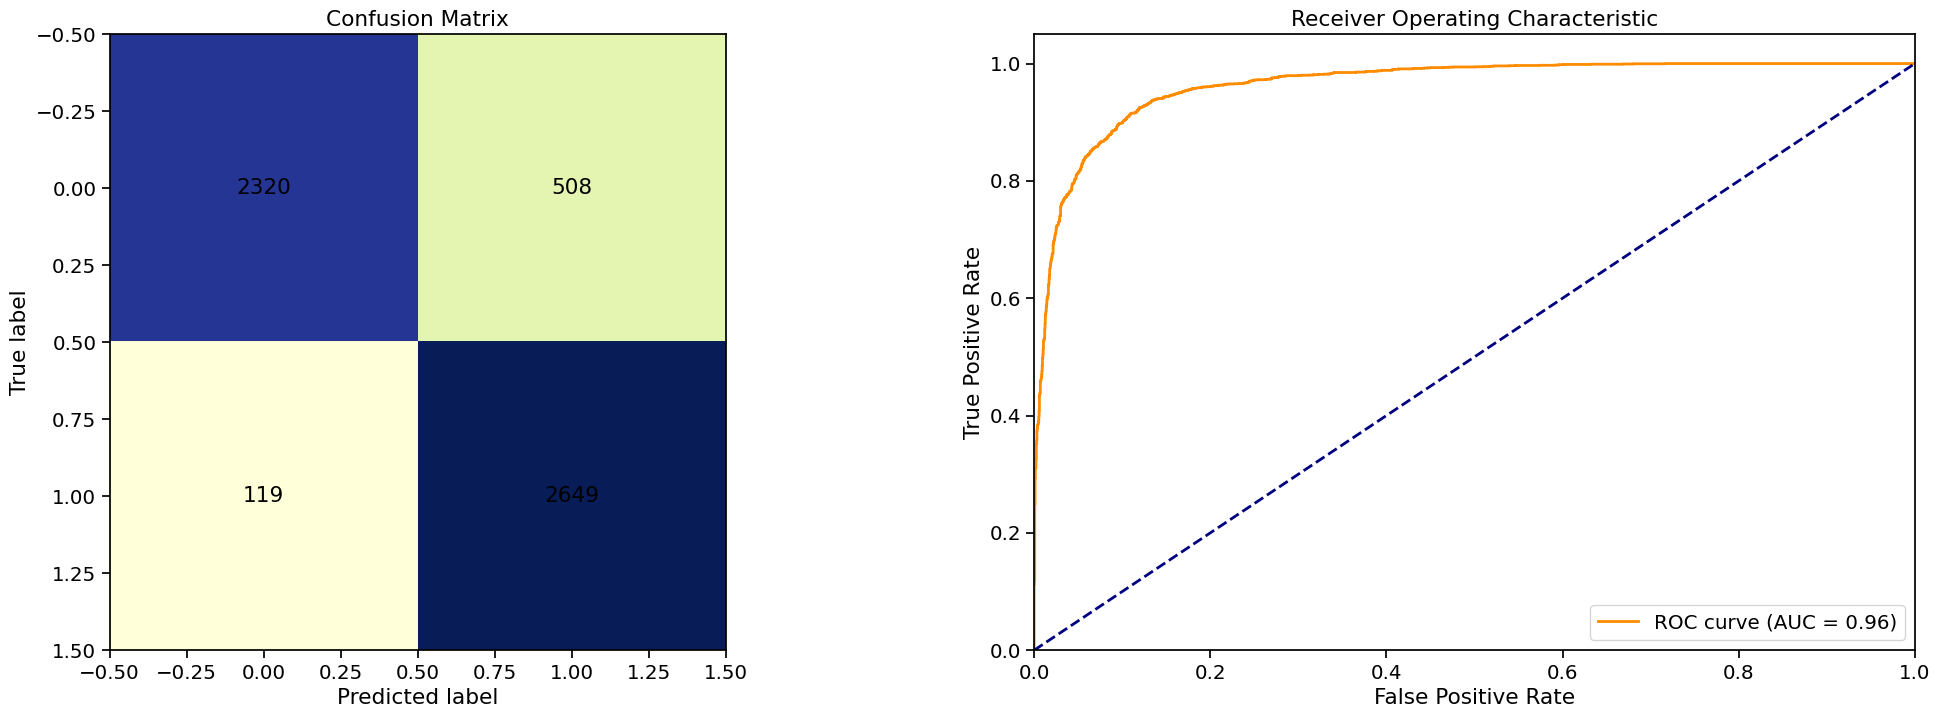

In [21]:
nb = MultinomialNB()
train_model(nb)

In [22]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [23]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(data['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 dear american teen question dutch person heard guy get way easier thing learn age us sooooo thth grader like right guy learn math 

After Tokenization & Padding 
 [1890  719  805  288 4306   68  558  108    5   37  771   21  338  344
  158    2   71  108  338 1028    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [24]:
y = data.label
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (15666, 100) (15666,)
Validation Set: (6715, 100) (6715,)
Test Set:       (5596, 100) (5596,)


In [25]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Компилируем модель
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5092 - loss: 0.6931 - val_accuracy: 0.5655 - val_loss: 0.6913
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5721 - loss: 0.6907 - val_accuracy: 0.6039 - val_loss: 0.6886
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5906 - loss: 0.6877 - val_accuracy: 0.6262 - val_loss: 0.6843
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6334 - loss: 0.6827 - val_accuracy: 0.6487 - val_loss: 0.6742
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6475 - loss: 0.6703 - val_accuracy: 0.6713 - val_loss: 0.6454
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6717 - loss: 0.6370 - val_accuracy: 0.6703 - val_loss: 0.6206
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6778 - loss: 0.6174 - val_accuracy: 0.6725 - val_loss: 0.6148
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6723 - loss: 0.6179 - val_ac

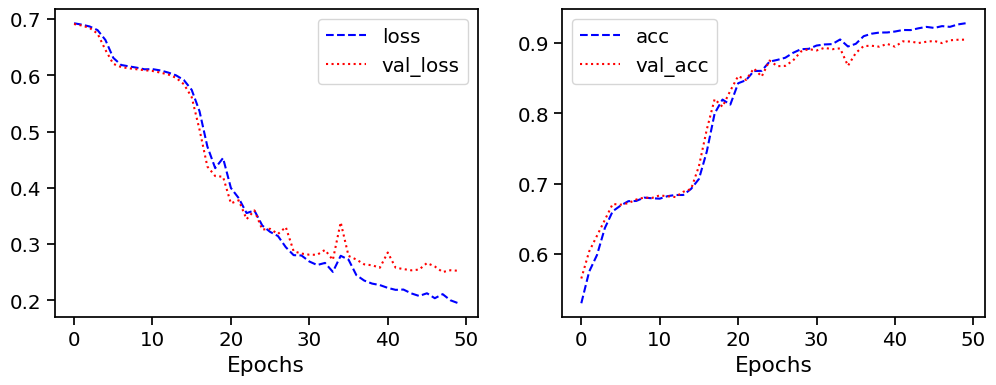

Accuracy  : 0.2513


In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

accuracy,recall= model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))